# Coordinate-Based Indexing Demo - Non-Integer Indexing for Specialized Data

This notebook demonstrates PyTorch's new coordinate-based sampling and indexing capabilities for data naturally indexed by continuous coordinates rather than discrete integers.

## Use Cases
- **Satellite Imagery**: Indexed by latitude/longitude coordinates
- **Medical Imaging**: Indexed by nanometer-scale positions for massive pathology slides

## Goals

- Demonstrate coordinate samplers for floating-point indices
- Show satellite imagery use case with lat/lon coordinates
- Show medical imaging use case with nanometer coordinates
- Validate integration with DataLoader and batch processing
- Demonstrate spatial batching for cache-efficient access patterns

In [2]:
# Import PyTorch from the local source checkout before any torch imports
import os
import sys
import time
from typing import Tuple, List

repo_root = os.path.abspath(os.path.join(os.getcwd(), "../../pytorch"))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import (
    CoordinateSampler,
    GridCoordinateSampler,
    WeightedCoordinateSampler,
    CoordinateBatchSampler,
    SpatialBatchSampler,
    create_coordinate_sampler,
    coordinates_to_tensor,
    tensor_to_coordinates,
)

import matplotlib.pyplot as plt
import numpy as np

# Configuration
DEVICE = torch.device("cpu")
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Running on: {DEVICE}")

PyTorch version: 2.10.0a0+git6ce24e4
Running on: cpu


---
# Part 1: Satellite Imagery - Latitude/Longitude Indexing

Satellite imagery is naturally indexed by geographic coordinates. Instead of accessing pixels by `image[row, col]`, we want to access data by `image[latitude, longitude]`.

## Scenario
A 10,000 x 10,000 pixel satellite image covering a geographic region:
- Latitude range: 34.0°N to 35.0°N (1 degree span)
- Longitude range: -118.5°W to -117.5°W (1 degree span, Los Angeles area)

In [3]:
class SatelliteImageDataset(Dataset):
    """Dataset that accepts (latitude, longitude) coordinates as indices.
    
    Simulates a satellite image where each pixel represents a geographic location.
    Uses bilinear interpolation for sub-pixel coordinate access.
    """
    
    def __init__(
        self,
        image_size: Tuple[int, int] = (10000, 10000),
        lat_range: Tuple[float, float] = (34.0, 35.0),
        lon_range: Tuple[float, float] = (-118.5, -117.5),
        channels: int = 4,  # RGBN (Red, Green, Blue, Near-Infrared)
    ):
        self.height, self.width = image_size
        self.lat_min, self.lat_max = lat_range
        self.lon_min, self.lon_max = lon_range
        self.channels = channels
        
        # Simulate satellite data with spatial patterns
        # Create a pattern that varies with geographic location
        y_coords = torch.linspace(0, 1, self.height).view(-1, 1)
        x_coords = torch.linspace(0, 1, self.width).view(1, -1)
        
        # Simulate different spectral bands
        self.data = torch.zeros(channels, self.height, self.width)
        self.data[0] = torch.sin(y_coords * 10) * torch.cos(x_coords * 8)  # Red
        self.data[1] = torch.cos(y_coords * 12) * torch.sin(x_coords * 6)  # Green
        self.data[2] = (y_coords + x_coords) / 2  # Blue (gradient)
        self.data[3] = torch.exp(-((y_coords - 0.5)**2 + (x_coords - 0.5)**2) * 5)  # NIR (center blob)
        
        print(f"Created satellite dataset: {image_size[0]}x{image_size[1]} pixels, {channels} bands")
        print(f"Geographic bounds: Lat [{lat_range[0]:.4f}, {lat_range[1]:.4f}], Lon [{lon_range[0]:.4f}, {lon_range[1]:.4f}]")
        
    def _latlon_to_pixel(self, lat: float, lon: float) -> Tuple[float, float]:
        """Convert lat/lon to pixel coordinates (can be fractional)."""
        # Normalize to [0, 1]
        lat_norm = (lat - self.lat_min) / (self.lat_max - self.lat_min)
        lon_norm = (lon - self.lon_min) / (self.lon_max - self.lon_min)
        
        # Convert to pixel coordinates
        row = (1 - lat_norm) * (self.height - 1)  # Lat increases upward
        col = lon_norm * (self.width - 1)
        
        return row, col
    
    def _bilinear_sample(self, row: float, col: float) -> torch.Tensor:
        """Sample with bilinear interpolation for sub-pixel accuracy."""
        # Get integer coordinates
        r0, c0 = int(row), int(col)
        r1, c1 = min(r0 + 1, self.height - 1), min(c0 + 1, self.width - 1)
        
        # Get fractional parts
        dr, dc = row - r0, col - c0
        
        # Bilinear interpolation
        val = (
            self.data[:, r0, c0] * (1 - dr) * (1 - dc) +
            self.data[:, r0, c1] * (1 - dr) * dc +
            self.data[:, r1, c0] * dr * (1 - dc) +
            self.data[:, r1, c1] * dr * dc
        )
        return val
    
    def __getitem__(self, index):
        """Accept (latitude, longitude) tuple and return spectral data."""
        if isinstance(index, tuple) and len(index) == 2:
            lat, lon = index
            
            # Validate bounds
            if not (self.lat_min <= lat <= self.lat_max):
                raise ValueError(f"Latitude {lat} out of bounds [{self.lat_min}, {self.lat_max}]")
            if not (self.lon_min <= lon <= self.lon_max):
                raise ValueError(f"Longitude {lon} out of bounds [{self.lon_min}, {self.lon_max}]")
            
            row, col = self._latlon_to_pixel(lat, lon)
            return self._bilinear_sample(row, col)
        else:
            raise TypeError(f"Expected (lat, lon) tuple, got {type(index)}")
    
    def __len__(self):
        return self.height * self.width


# Create the satellite dataset
satellite = SatelliteImageDataset()

Created satellite dataset: 10000x10000 pixels, 4 bands
Geographic bounds: Lat [34.0000, 35.0000], Lon [-118.5000, -117.5000]


## 1.1 Basic Coordinate Access

Demonstrate accessing satellite data using latitude/longitude coordinates directly.

In [4]:
# Access specific geographic locations
test_locations = [
    (34.0, -118.5),   # Southwest corner
    (35.0, -117.5),   # Northeast corner
    (34.5, -118.0),   # Center
    (34.25, -118.25), # Quarter point
]

print("Sampling satellite data at specific coordinates:")
print("-" * 60)
for lat, lon in test_locations:
    spectral = satellite[(lat, lon)]
    print(f"  Lat: {lat:7.4f}°N, Lon: {lon:8.4f}°W")
    print(f"    R: {spectral[0]:.4f}, G: {spectral[1]:.4f}, B: {spectral[2]:.4f}, NIR: {spectral[3]:.4f}")
    print()

Sampling satellite data at specific coordinates:
------------------------------------------------------------
  Lat: 34.0000°N, Lon: -118.5000°W
    R: -0.5440, G: 0.0000, B: 0.5000, NIR: 0.0821

  Lat: 35.0000°N, Lon: -117.5000°W
    R: -0.0000, G: -0.2794, B: 0.5000, NIR: 0.0821

  Lat: 34.5000°N, Lon: -118.0000°W
    R: 0.6268, G: 0.1355, B: 0.5000, NIR: 1.0000

  Lat: 34.2500°N, Lon: -118.2500°W
    R: -0.3903, G: -0.9088, B: 0.5000, NIR: 0.5353



## 1.2 Grid Coordinate Sampler for Satellite Imagery

Create a regular grid of sample points across the geographic region.

In [5]:
# Create a grid sampler for the satellite region
# Note: bounds are (lat_min, lon_min, lat_max, lon_max) but GridCoordinateSampler uses (x_min, y_min, x_max, y_max)
# We'll treat latitude as x and longitude as y for this example

grid_sampler = GridCoordinateSampler(
    bounds=(34.0, -118.5, 35.0, -117.5),  # (lat_min, lon_min, lat_max, lon_max)
    grid_size=(10, 10),  # 10x10 grid = 100 sample points
    mode='regular',
    include_edges=True,
    shuffle=False
)

print(f"Grid sampler created with {len(grid_sampler)} sample points")
print("\nFirst 5 sample coordinates (lat, lon):")
for i, coord in enumerate(grid_sampler):
    if i >= 5:
        break
    print(f"  {i}: ({coord[0]:.4f}°N, {coord[1]:.4f}°W)")

Grid sampler created with 100 sample points

First 5 sample coordinates (lat, lon):
  0: (34.0000°N, -118.5000°W)
  1: (34.1111°N, -118.5000°W)
  2: (34.2222°N, -118.5000°W)
  3: (34.3333°N, -118.5000°W)
  4: (34.4444°N, -118.5000°W)


In [6]:
# Sample the satellite data using the grid sampler
print("Sampling satellite data on regular grid:")
print("-" * 60)

samples = []
coords = []
for coord in grid_sampler:
    lat, lon = coord
    spectral = satellite[(lat, lon)]
    samples.append(spectral)
    coords.append(coord)

samples_tensor = torch.stack(samples)
print(f"Collected {len(samples)} samples")
print(f"Sample tensor shape: {samples_tensor.shape}")
print(f"Mean spectral values: R={samples_tensor[:, 0].mean():.4f}, G={samples_tensor[:, 1].mean():.4f}, B={samples_tensor[:, 2].mean():.4f}, NIR={samples_tensor[:, 3].mean():.4f}")

Sampling satellite data on regular grid:
------------------------------------------------------------
Collected 100 samples
Sample tensor shape: torch.Size([100, 4])
Mean spectral values: R=0.0177, G=-0.0005, B=0.5000, NIR=0.4332


## 1.3 Weighted Sampling for Areas of Interest

In remote sensing, certain regions may be more important (e.g., urban areas, water bodies). Use weighted sampling to oversample these regions.

In [7]:
# Create coordinates with importance weights
# Simulate higher weights for the center of the image (e.g., urban area)

sample_coords = [(lat, lon) for lat, lon in coords]  # Reuse grid coordinates

# Calculate weights based on distance from center (center is more important)
center_lat, center_lon = 34.5, -118.0
weights = []
for lat, lon in sample_coords:
    dist = ((lat - center_lat)**2 + (lon - center_lon)**2) ** 0.5
    weight = max(0.1, 1.0 - dist * 2)  # Higher weight near center
    weights.append(weight)

weighted_sampler = WeightedCoordinateSampler(
    coordinates=sample_coords,
    weights=weights,
    num_samples=50,
    replacement=True
)

print(f"Weighted sampler will draw {len(weighted_sampler)} samples")

# Count how many samples come from different regions
from collections import Counter
sampled_coords = list(weighted_sampler)
inner_count = sum(1 for lat, lon in sampled_coords 
                  if abs(lat - center_lat) < 0.25 and abs(lon - center_lon) < 0.25)

print(f"Samples from inner region (near center): {inner_count}/{len(sampled_coords)} ({100*inner_count/len(sampled_coords):.1f}%)")

Weighted sampler will draw 50 samples
Samples from inner region (near center): 17/50 (34.0%)


## 1.4 DataLoader Integration

Use coordinate samplers with PyTorch's DataLoader for batch processing.

In [8]:
# Create a coordinate sampler with shuffling
all_coords = list(GridCoordinateSampler(
    bounds=(34.0, -118.5, 35.0, -117.5),
    grid_size=(20, 20),
    mode='regular'
))

coord_sampler = CoordinateSampler(all_coords, shuffle=True, seed=42)

# Create DataLoader with batch_size=None (sampler yields individual items)
loader = DataLoader(satellite, sampler=coord_sampler, batch_size=None)

print(f"DataLoader created with {len(coord_sampler)} samples")

# Iterate through a few batches
batch_count = 0
for data in loader:
    if batch_count < 3:
        print(f"Sample {batch_count}: shape={data.shape}, values={data.numpy().round(3)}")
    batch_count += 1

print(f"\nTotal samples processed: {batch_count}")

DataLoader created with 400 samples
Sample 0: shape=torch.Size([4]), values=[0.295 0.203 0.895 0.211]
Sample 1: shape=torch.Size([4]), values=[ 0.502 -0.807  0.421  0.242]
Sample 2: shape=torch.Size([4]), values=[0.53  0.349 0.737 0.555]

Total samples processed: 400


## 1.5 Visualization of Satellite Sampling

Visualize the sampling patterns on the satellite image.

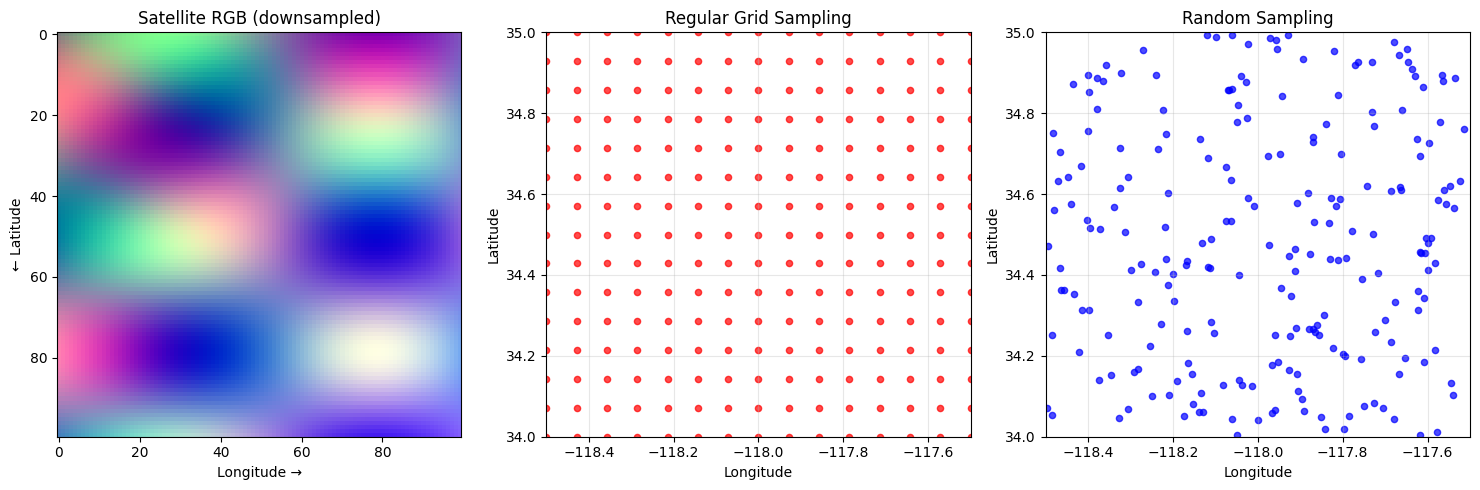

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Show the satellite image (RGB composite, downsampled)
downsample = 100
rgb = satellite.data[:3, ::downsample, ::downsample].permute(1, 2, 0)
rgb_normalized = (rgb - rgb.min()) / (rgb.max() - rgb.min())

axes[0].imshow(rgb_normalized.numpy())
axes[0].set_title("Satellite RGB (downsampled)")
axes[0].set_xlabel("Longitude →")
axes[0].set_ylabel("← Latitude")

# Show regular grid sampling pattern
grid_coords = list(GridCoordinateSampler(
    bounds=(34.0, -118.5, 35.0, -117.5),
    grid_size=(15, 15),
    mode='regular'
))
lats = [c[0] for c in grid_coords]
lons = [c[1] for c in grid_coords]

axes[1].scatter(lons, lats, c='red', s=20, alpha=0.7)
axes[1].set_xlim(-118.5, -117.5)
axes[1].set_ylim(34.0, 35.0)
axes[1].set_title("Regular Grid Sampling")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].grid(True, alpha=0.3)

# Show random sampling pattern
random_coords = list(GridCoordinateSampler(
    bounds=(34.0, -118.5, 35.0, -117.5),
    grid_size=(15, 15),
    mode='random'
))
lats = [c[0] for c in random_coords]
lons = [c[1] for c in random_coords]

axes[2].scatter(lons, lats, c='blue', s=20, alpha=0.7)
axes[2].set_xlim(-118.5, -117.5)
axes[2].set_ylim(34.0, 35.0)
axes[2].set_title("Random Sampling")
axes[2].set_xlabel("Longitude")
axes[2].set_ylabel("Latitude")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
# Part 2: Medical Imaging - Nanometer-Scale Indexing

Whole-slide pathology images can be 100,000+ pixels in each dimension. At 40x magnification, each pixel represents ~0.25 micrometers. For electron microscopy, we need nanometer precision.

## Scenario
A 50,000 x 50,000 pixel pathology slide:
- Physical size: 12.5mm x 12.5mm (at 0.25 μm/pixel)
- Coordinate range: 0 to 12,500,000 nanometers in each dimension

In [10]:
class MedicalSlideDataset(Dataset):
    """Dataset that accepts nanometer coordinates as indices.
    
    Simulates a whole-slide pathology image with nanometer-scale indexing.
    """
    
    def __init__(
        self,
        image_size: Tuple[int, int] = (50000, 50000),
        nm_per_pixel: float = 250.0,  # 0.25 micrometers = 250 nanometers
        channels: int = 3,  # RGB stain
    ):
        self.height, self.width = image_size
        self.nm_per_pixel = nm_per_pixel
        self.channels = channels
        
        # Physical dimensions in nanometers
        self.nm_height = self.height * nm_per_pixel
        self.nm_width = self.width * nm_per_pixel
        
        # Simulate tissue with cellular structures
        # Create patterns at different scales
        y_coords = torch.linspace(0, 1, min(self.height, 5000)).view(-1, 1)
        x_coords = torch.linspace(0, 1, min(self.width, 5000)).view(1, -1)
        
        # Simulate H&E staining patterns
        self.data = torch.zeros(channels, min(self.height, 5000), min(self.width, 5000))
        
        # Hematoxylin (blue-purple, stains nuclei)
        nuclei = torch.zeros_like(self.data[0])
        for _ in range(100):
            cx, cy = torch.rand(2)
            nuclei += torch.exp(-((x_coords - cx)**2 + (y_coords - cy)**2) * 500)
        self.data[2] = nuclei.clamp(0, 1)  # Blue channel
        
        # Eosin (pink, stains cytoplasm)
        self.data[0] = 0.8 - self.data[2] * 0.3  # Red channel
        self.data[1] = 0.6 - self.data[2] * 0.2  # Green channel
        
        print(f"Created medical slide dataset:")
        print(f"  Image size: {image_size[0]:,} x {image_size[1]:,} pixels")
        print(f"  Resolution: {nm_per_pixel} nm/pixel ({nm_per_pixel/1000:.3f} μm/pixel)")
        print(f"  Physical size: {self.nm_width/1e6:.2f} mm x {self.nm_height/1e6:.2f} mm")
        print(f"  Coordinate range: 0 to {self.nm_width:,.0f} nm")
        
    def _nm_to_pixel(self, nm_x: float, nm_y: float) -> Tuple[float, float]:
        """Convert nanometer coordinates to pixel coordinates."""
        # Scale to actual data size (which may be downsampled)
        actual_height = self.data.shape[1]
        actual_width = self.data.shape[2]
        
        row = (nm_y / self.nm_height) * (actual_height - 1)
        col = (nm_x / self.nm_width) * (actual_width - 1)
        
        return row, col
    
    def _bilinear_sample(self, row: float, col: float) -> torch.Tensor:
        """Sample with bilinear interpolation."""
        actual_height = self.data.shape[1]
        actual_width = self.data.shape[2]
        
        row = max(0, min(row, actual_height - 1))
        col = max(0, min(col, actual_width - 1))
        
        r0, c0 = int(row), int(col)
        r1 = min(r0 + 1, actual_height - 1)
        c1 = min(c0 + 1, actual_width - 1)
        
        dr, dc = row - r0, col - c0
        
        val = (
            self.data[:, r0, c0] * (1 - dr) * (1 - dc) +
            self.data[:, r0, c1] * (1 - dr) * dc +
            self.data[:, r1, c0] * dr * (1 - dc) +
            self.data[:, r1, c1] * dr * dc
        )
        return val
    
    def __getitem__(self, index):
        """Accept (nm_x, nm_y) tuple and return stain intensities."""
        if isinstance(index, tuple) and len(index) == 2:
            nm_x, nm_y = index
            
            # Validate bounds
            if not (0 <= nm_x <= self.nm_width):
                raise ValueError(f"X coordinate {nm_x} nm out of bounds [0, {self.nm_width}]")
            if not (0 <= nm_y <= self.nm_height):
                raise ValueError(f"Y coordinate {nm_y} nm out of bounds [0, {self.nm_height}]")
            
            row, col = self._nm_to_pixel(nm_x, nm_y)
            return self._bilinear_sample(row, col)
        else:
            raise TypeError(f"Expected (nm_x, nm_y) tuple, got {type(index)}")
    
    def __len__(self):
        return self.height * self.width


# Create the medical slide dataset
slide = MedicalSlideDataset()

Created medical slide dataset:
  Image size: 50,000 x 50,000 pixels
  Resolution: 250.0 nm/pixel (0.250 μm/pixel)
  Physical size: 12.50 mm x 12.50 mm
  Coordinate range: 0 to 12,500,000 nm


## 2.1 Nanometer-Precision Access

Access tissue data at specific nanometer coordinates.

In [11]:
# Sample at specific nanometer locations
test_positions = [
    (0, 0),                           # Origin
    (6_250_000, 6_250_000),            # Center (half of 12.5mm)
    (1_000_000, 1_000_000),            # 1mm from origin
    (1_000_250, 1_000_250),            # 250nm offset (sub-pixel)
    (12_500_000, 12_500_000),          # Maximum
]

print("Sampling slide at nanometer coordinates:")
print("-" * 70)
for nm_x, nm_y in test_positions:
    stain = slide[(nm_x, nm_y)]
    print(f"  Position: ({nm_x/1e6:7.4f} mm, {nm_y/1e6:7.4f} mm) = ({nm_x:>12,} nm, {nm_y:>12,} nm)")
    print(f"    H&E stain: R={stain[0]:.4f}, G={stain[1]:.4f}, B={stain[2]:.4f}")
    print()

Sampling slide at nanometer coordinates:
----------------------------------------------------------------------
  Position: ( 0.0000 mm,  0.0000 mm) = (           0 nm,            0 nm)
    H&E stain: R=0.6935, G=0.5290, B=0.3549

  Position: ( 6.2500 mm,  6.2500 mm) = (   6,250,000 nm,    6,250,000 nm)
    H&E stain: R=0.5870, G=0.4580, B=0.7101

  Position: ( 1.0000 mm,  1.0000 mm) = (   1,000,000 nm,    1,000,000 nm)
    H&E stain: R=0.6684, G=0.5123, B=0.4387

  Position: ( 1.0003 mm,  1.0003 mm) = (   1,000,250 nm,    1,000,250 nm)
    H&E stain: R=0.6685, G=0.5124, B=0.4382

  Position: (12.5000 mm, 12.5000 mm) = (  12,500,000 nm,   12,500,000 nm)
    H&E stain: R=0.8000, G=0.6000, B=0.0000



## 2.2 Sub-Pixel Precision Demonstration

Show that nanometer indexing provides sub-pixel accuracy through interpolation.

In [12]:
# Sample across a single pixel at nanometer resolution
# At 250 nm/pixel, moving 50nm should change the interpolated value

base_x, base_y = 5_000_000, 5_000_000  # 5mm position
nm_step = 50  # 50 nanometer steps

print(f"Sub-pixel sampling across 250nm (one pixel width) at ({base_x/1e6}mm, {base_y/1e6}mm):")
print("-" * 60)

for offset in range(0, 300, nm_step):
    stain = slide[(base_x + offset, base_y)]
    print(f"  Offset: {offset:3d} nm ({offset/250:.2f} pixels) -> B-channel: {stain[2]:.6f}")

Sub-pixel sampling across 250nm (one pixel width) at (5.0mm, 5.0mm):
------------------------------------------------------------
  Offset:   0 nm (0.00 pixels) -> B-channel: 0.575837
  Offset:  50 nm (0.20 pixels) -> B-channel: 0.575898
  Offset: 100 nm (0.40 pixels) -> B-channel: 0.575960
  Offset: 150 nm (0.60 pixels) -> B-channel: 0.576021
  Offset: 200 nm (0.80 pixels) -> B-channel: 0.576083
  Offset: 250 nm (1.00 pixels) -> B-channel: 0.576144


## 2.3 Region of Interest Sampling

Sample a specific tissue region at high density for detailed analysis.

In [13]:
# Define a region of interest (ROI) in nanometer coordinates
# A 100 micrometer square region (100,000 nm)
roi_x_min = 6_000_000  # 6mm from left edge
roi_y_min = 6_000_000  # 6mm from top edge
roi_size = 100_000     # 100 micrometers = 100,000 nm

# Create a grid sampler for this ROI
roi_sampler = GridCoordinateSampler(
    bounds=(roi_x_min, roi_y_min, roi_x_min + roi_size, roi_y_min + roi_size),
    grid_size=(20, 20),  # 20x20 sample points
    mode='regular'
)

print(f"ROI Sampler for region:")
print(f"  Position: ({roi_x_min/1e6:.2f}mm, {roi_y_min/1e6:.2f}mm)")
print(f"  Size: {roi_size/1e3:.0f}μm x {roi_size/1e3:.0f}μm")
print(f"  Samples: {len(roi_sampler)}")
print(f"  Sample spacing: {roi_size/19/1e3:.2f}μm = {roi_size/19:.0f}nm")

# Collect samples
roi_samples = []
for coord in roi_sampler:
    stain = slide[coord]
    roi_samples.append(stain)

roi_tensor = torch.stack(roi_samples)
print(f"\nCollected samples tensor shape: {roi_tensor.shape}")
print(f"Mean stain values: R={roi_tensor[:, 0].mean():.4f}, G={roi_tensor[:, 1].mean():.4f}, B={roi_tensor[:, 2].mean():.4f}")

ROI Sampler for region:
  Position: (6.00mm, 6.00mm)
  Size: 100μm x 100μm
  Samples: 400
  Sample spacing: 5.26μm = 5263nm

Collected samples tensor shape: torch.Size([400, 3])
Mean stain values: R=0.5247, G=0.4165, B=0.9176


## 2.4 Spatial Batch Sampling for Cache Efficiency

When processing large medical images, reading spatially nearby regions together improves cache performance.

In [14]:
# Generate sample coordinates across the slide
all_sample_coords = list(GridCoordinateSampler(
    bounds=(0, 0, slide.nm_width, slide.nm_height),
    grid_size=(50, 50),  # 2500 sample points
    mode='regular'
))

# Create spatial batch sampler
spatial_sampler = SpatialBatchSampler(
    coordinates=all_sample_coords,
    batch_size=64,
    shuffle_batches=False
)

print(f"Spatial batch sampler:")
print(f"  Total samples: {len(all_sample_coords)}")
print(f"  Batch size: 64")
print(f"  Number of batches: {len(spatial_sampler)}")

# Analyze spatial coherence of batches
print("\nBatch spatial analysis (first 3 batches):")
for i, batch in enumerate(spatial_sampler):
    if i >= 3:
        break
    xs = [c[0] for c in batch]
    ys = [c[1] for c in batch]
    x_range = (max(xs) - min(xs)) / 1e6  # Convert to mm
    y_range = (max(ys) - min(ys)) / 1e6
    print(f"  Batch {i}: {len(batch)} coords, spatial extent: {x_range:.2f}mm x {y_range:.2f}mm")

Spatial batch sampler:
  Total samples: 2500
  Batch size: 64
  Number of batches: 40

Batch spatial analysis (first 3 batches):
  Batch 0: 64 coords, spatial extent: 2.04mm x 1.79mm
  Batch 1: 64 coords, spatial extent: 4.08mm x 2.04mm
  Batch 2: 64 coords, spatial extent: 3.83mm x 2.04mm


## 2.5 Visualization of Medical Sampling

Visualize the simulated pathology slide and sampling patterns.

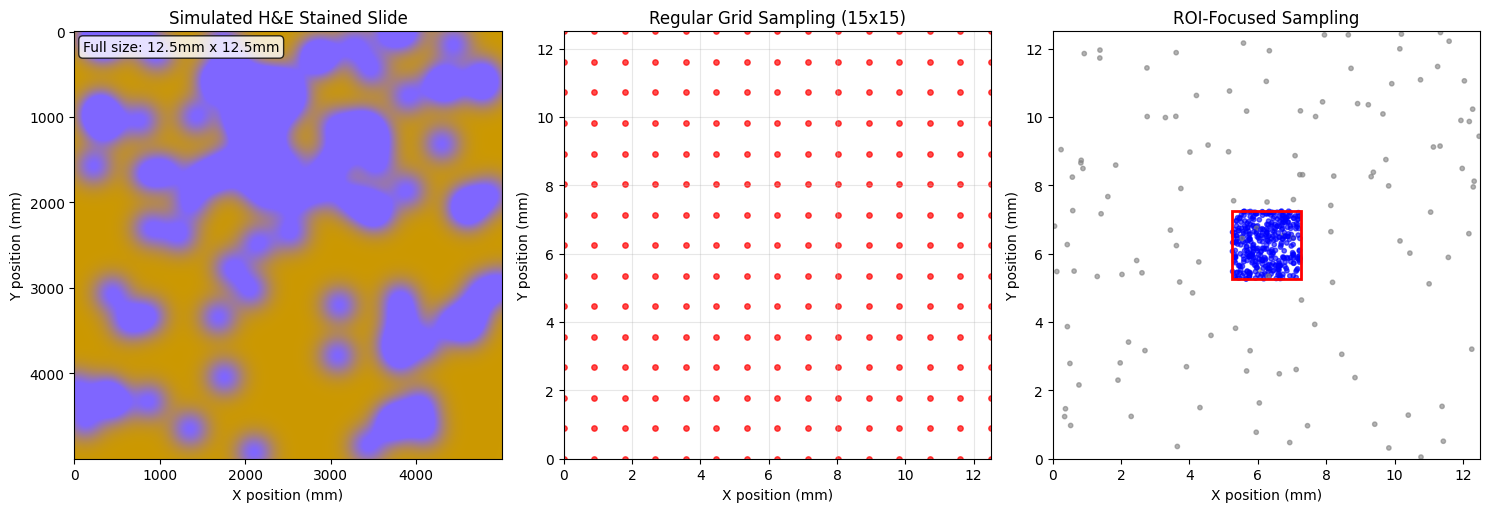

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Show the H&E stained slide (downsampled)
rgb = slide.data.permute(1, 2, 0).numpy()
rgb_clipped = np.clip(rgb, 0, 1)

axes[0].imshow(rgb_clipped)
axes[0].set_title("Simulated H&E Stained Slide")
axes[0].set_xlabel("X position (mm)")
axes[0].set_ylabel("Y position (mm)")
# Add scale bar annotation
axes[0].text(0.02, 0.98, f"Full size: {slide.nm_width/1e6:.1f}mm x {slide.nm_height/1e6:.1f}mm",
             transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Show regular grid sampling in nanometer space
grid_coords = list(GridCoordinateSampler(
    bounds=(0, 0, slide.nm_width, slide.nm_height),
    grid_size=(15, 15),
    mode='regular'
))
xs_mm = [c[0]/1e6 for c in grid_coords]
ys_mm = [c[1]/1e6 for c in grid_coords]

axes[1].scatter(xs_mm, ys_mm, c='red', s=15, alpha=0.7)
axes[1].set_xlim(0, slide.nm_width/1e6)
axes[1].set_ylim(0, slide.nm_height/1e6)
axes[1].set_title("Regular Grid Sampling (15x15)")
axes[1].set_xlabel("X position (mm)")
axes[1].set_ylabel("Y position (mm)")
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

# Show ROI focused sampling
roi_x_center, roi_y_center = 6.25, 6.25  # Center in mm
roi_size_mm = 2.0  # 2mm ROI

# Random samples, denser near ROI
all_xs, all_ys, colors = [], [], []
for _ in range(500):
    if torch.rand(1).item() < 0.7:  # 70% in ROI
        x = roi_x_center + (torch.rand(1).item() - 0.5) * roi_size_mm
        y = roi_y_center + (torch.rand(1).item() - 0.5) * roi_size_mm
        colors.append('blue')
    else:  # 30% outside
        x = torch.rand(1).item() * slide.nm_width/1e6
        y = torch.rand(1).item() * slide.nm_height/1e6
        colors.append('gray')
    all_xs.append(x)
    all_ys.append(y)

axes[2].scatter(all_xs, all_ys, c=colors, s=10, alpha=0.6)
# Draw ROI box
from matplotlib.patches import Rectangle
rect = Rectangle((roi_x_center - roi_size_mm/2, roi_y_center - roi_size_mm/2),
                  roi_size_mm, roi_size_mm, fill=False, edgecolor='red', linewidth=2)
axes[2].add_patch(rect)
axes[2].set_xlim(0, slide.nm_width/1e6)
axes[2].set_ylim(0, slide.nm_height/1e6)
axes[2].set_title("ROI-Focused Sampling")
axes[2].set_xlabel("X position (mm)")
axes[2].set_ylabel("Y position (mm)")
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

---
# Part 3: Coordinate Tensor Utilities

Helper functions for converting between coordinate lists and tensors.

In [16]:
# Convert coordinate list to tensor
sample_coords = [(34.5, -118.0), (34.6, -118.1), (34.7, -118.2)]
coord_tensor = coordinates_to_tensor(sample_coords)

print("Coordinate list to tensor:")
print(f"  Input: {sample_coords}")
print(f"  Output shape: {coord_tensor.shape}")
print(f"  Output:\n{coord_tensor}")

# Convert tensor back to coordinates
recovered_coords = tensor_to_coordinates(coord_tensor)
print(f"\nRecovered coordinates: {recovered_coords}")

# Create sampler from tensor directly
random_tensor = torch.rand(100, 2) * torch.tensor([1.0, 1.0]) + torch.tensor([34.0, -118.5])
tensor_sampler = create_coordinate_sampler(random_tensor, 'random', seed=42)
print(f"\nSampler from tensor: {len(tensor_sampler)} coordinates")

Coordinate list to tensor:
  Input: [(34.5, -118.0), (34.6, -118.1), (34.7, -118.2)]
  Output shape: torch.Size([3, 2])
  Output:
tensor([[  34.5000, -118.0000],
        [  34.6000, -118.1000],
        [  34.7000, -118.2000]])

Recovered coordinates: [(34.5, -118.0), (34.599998474121094, -118.0999984741211), (34.70000076293945, -118.19999694824219)]

Sampler from tensor: 100 coordinates


---
# Summary

This notebook demonstrated PyTorch's new non-integer coordinate indexing capabilities:

## Satellite Imagery (Lat/Lon)
- `CoordinateSampler`: Basic shuffled/sequential sampling of geographic coordinates
- `GridCoordinateSampler`: Regular or random grid sampling within geographic bounds
- `WeightedCoordinateSampler`: Priority sampling for areas of interest

## Medical Imaging (Nanometers)
- Sub-pixel precision through bilinear interpolation
- `SpatialBatchSampler`: Cache-efficient batching of nearby samples
- ROI-focused sampling for detailed analysis

## Key Benefits
1. **Natural indexing**: Access data using domain-specific coordinates (lat/lon, nm, etc.)
2. **Sub-pixel precision**: Bilinear interpolation for continuous coordinate access
3. **DataLoader integration**: Works seamlessly with PyTorch's data loading infrastructure
4. **Spatial efficiency**: Batch nearby samples together for better cache performance